# Clustering Algorithms and Results

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import plotly.express as px
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import DBSCAN
import skfuzzy as fuzz
from scipy.cluster.hierarchy import fcluster
from sklearn.decomposition import PCA
import os
from inspect import getsourcefile
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from skfuzzy.cluster import cmeans as FuzzyCMeans
import numpy as np
import random
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
import seaborn as sns

## 1. Importing the already pre-processed dataframe

In [7]:
mean_ranked = pd.read_csv("Dataframes/final_mean_ranked.csv")
mean_ranked = mean_ranked.rename(columns={'timestamp': 'Stock_ticker'})

mean_scaled = pd.read_csv("Dataframes/final_mean_scaled.csv")
mean_scaled = mean_scaled.rename(columns={'timestamp': 'Stock_ticker'})

ranked_betas = pd.read_csv("Dataframes/final_ranked_betas.csv")
ranked_betas = ranked_betas.rename(columns={'timestamp': 'Stock_ticker'})

ranked_correls = pd.read_csv("Dataframes/final_rank_correls.csv")
ranked_correls = ranked_correls.rename(columns={'timestamp': 'Stock_ticker'})

scaled_betas = pd.read_csv("Dataframes/final_scaled_betas.csv")
scaled_betas = scaled_betas.rename(columns={'timestamp': 'Stock_ticker'})

scaled_correls = pd.read_csv("Dataframes/final_scaled_correls.csv")
scaled_correls = scaled_correls.rename(columns={'timestamp': 'Stock_ticker'})

dfs = [mean_ranked, mean_scaled, ranked_betas, ranked_correls, scaled_betas, scaled_correls]

## 2. Building PCA Model to reduce the number of features to 10

10 PC due to the elbow plot as seen in our powerpoint slides appendix

In [8]:
dfs_names = [('mean_ranked', mean_ranked), ('mean_scaled', mean_scaled), ('ranked_betas', ranked_betas), ('ranked_correls', ranked_correls), ('scaled_betas', scaled_betas), ('scaled_correls', scaled_correls)]

for df_name, df in dfs_names:
    # drop the first column of the dataframe before applying PCA
    df_without_first_col = df.iloc[:, 1:]
    
    # create a PCA object with n_components=10
    pca = PCA(n_components=10)
    
    # fit the PCA object to the dataframe without the first column
    pca.fit(df_without_first_col)
    
    # transform the dataframe without the first column using the PCA object
    transformed = pca.transform(df_without_first_col)
    
    # create a new dataframe with the transformed data and the first column included
    new_df = pd.concat([df.iloc[:, 0], pd.DataFrame(data=transformed, columns=[f'pc{i}' for i in range(1, 11)])], axis=1)
    
    # create a new file name with the dataframe name and "_PCA" appended to the original file name, and remove the first 11 characters
    new_file_name = f'Dataframes/{df_name}_PCA.csv'
    
    # save the new dataframe to a file with the new file name
    new_df.to_csv(new_file_name, index=False)

## 3. Importing the Dataframes with less features after using PCA method

In [9]:
mean_ranked_PCA = pd.read_csv("Dataframes/mean_ranked_PCA.csv")
mean_scaled_PCA = pd.read_csv("Dataframes/mean_scaled_PCA.csv")
ranked_betas_PCA = pd.read_csv("Dataframes/ranked_betas_PCA.csv")
ranked_correls_PCA = pd.read_csv("Dataframes/ranked_correls_PCA.csv")
scaled_betas_PCA = pd.read_csv("Dataframes/scaled_betas_PCA.csv")
scaled_correls_PCA = pd.read_csv("Dataframes/scaled_correls_PCA.csv")

## 4. Building a loop for 12 Datadframes (without PCA & PCA), 4 Clustering Depths, and 3 Algorithms.

In [10]:
# set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed) 
random.seed(random_seed) 

# create a list of dataframes to iterate over
df_list = [mean_ranked, mean_scaled, ranked_betas, ranked_correls, scaled_betas, scaled_correls, mean_ranked_PCA, mean_scaled_PCA, ranked_betas_PCA, ranked_correls_PCA, scaled_betas_PCA, scaled_correls_PCA]

# initialize an empty dataframe to store results
results = pd.DataFrame(columns=["Stock"])

# define cluster depths to iterate over
cluster_depths = [11, 25, 67, 126]

# loop through cluster depths and dataframes
for n_clusters in cluster_depths:

    for df_name, df in zip(["mean_ranked", "mean_scaled", "ranked_betas", "ranked_correls", "scaled_betas", "scaled_correls", "mean_ranked_PCA", "mean_scaled_PCA", "ranked_betas_PCA", "ranked_correls_PCA", "scaled_betas_PCA", "scaled_correls_PCA"], df_list):
        
        # initialize a dictionary of clustering algorithms to use
        cluster_algos = {
            "KMeans": {"model": KMeans(), "params": {"n_clusters": [n_clusters], "max_iter": [50, 100, 500, 1000]}},
            "GMM": {"model": GaussianMixture(), "params": {"n_components": [n_clusters], "covariance_type": ["full", "tied", "diag", "spherical"]}},
            "Hierarchical": {"model": AgglomerativeClustering(), "params": {"n_clusters": [n_clusters], "linkage": ["ward", "complete", "average", "single"]}},
        }
        
        # create a dataframe to store results for this dataframe and clustering algorithm combination
        df_result = pd.DataFrame({"Stock": df.iloc[:, 0]})
        df_data = df.iloc[:, 1:] # extract data to cluster
        
        # loop through clustering algorithms
        for algo_name, algo_dict in cluster_algos.items():
            algo_model = algo_dict["model"]
            algo_params = algo_dict["params"]
            algo_grid = ParameterGrid(algo_params)

            best_score = None
            best_algo_result = None
            best_params = None # initialize best_params

            # loop through all possible combinations of hyperparameters for this algorithm
            for params in algo_grid:
                algo_model.set_params(**params)
                algo_results = algo_model.fit_predict(df_data)

                if len(np.unique(algo_results)) > 1: # check that there is more than one cluster
                    score = silhouette_score(df_data, algo_results) # calculate silhouette score

                    if best_score is None or score > best_score: # update best_score and best_algo_result if current score is better
                        best_score = score
                        best_algo_result = algo_results
                        best_params = params # update best_params

            # add the best results for this algorithm to the df_result dataframe
            df_result[f"{algo_name}_{n_clusters}_{df_name}"] = best_algo_result
            #print(f"Best hyperparameter combination for {algo_name} algorithm with {n_clusters} clusters and {df_name} data: {best_params}")

        # merge results with df_result and save results 
        results = pd.merge(results, df_result, on="Stock", how="outer")
        results.to_excel("Dataframes/results_after_3_algos_grid_search.xlsx", index=False)

In [11]:
three_algos = pd.read_excel("Dataframes/results_after_3_algos_grid_search.xlsx")

In [12]:
# separating the results by our 4 cluster depths
combinations = int(three_algos.iloc[:,1:].shape[1]/4)
three_algos_11  = three_algos.iloc[:,1:combinations+1]
three_algos_25  = three_algos.iloc[:,combinations+1:2*combinations+1]
three_algos_67  = three_algos.iloc[:,2*combinations+1:3*combinations+1]
three_algos_126 = three_algos.iloc[:,3*combinations+1:]


## 5. Get Stock Return time series for the Test Period

In [13]:
timeseries = pd.read_csv("Dataframes/final_stock_timeseries.csv")
timeseries = timeseries.set_index(timeseries.columns[0])

In [14]:
# train test split
def data_split(data, start_date, mid_date, end_date):
    first_part = data.loc[start_date:mid_date]
    second_part = data.loc[mid_date:end_date]

    return first_part, second_part[1:]

In [15]:
train_data, test_data,  = data_split(timeseries, "2020-01-08", "2022-12-31", "2023-3-31")

# for later ():
corr_matrix_train = train_data.corr()
corr_matrix_test = test_data.corr()

var_covar_matrix_train = train_data.cov()
var_covar_matrix_train = test_data.cov()

## 6. Get the GICS Clusters for Benchmarking

In [16]:
GICS = pd.read_csv("Dataframes/sector_classes_code_{}.csv")

In [17]:
GICS

,timestamp,Instrument,GICS Sector Code,GICS Industry Group Code,GICS Industry Code,GICS Sub-Industry Code
0,0,PEP.OQ,30,3020,302010,30201030
1,1,CDW.OQ,45,4520,452030,45203030
2,2,USB.N,40,4010,401010,40101010
3,3,RF.N,40,4010,401010,40101015
4,4,AAL.OQ,20,2030,203020,20302010
...,...,...,...,...,...,...
493,493,TDG.N,20,2010,201010,20101010
494,494,TYL.N,45,4510,451030,45103010
495,495,QCOM.OQ,45,4530,453010,45301020
496,496,DHR.N,35,3520,352030,35203010


## 7. Calculate avg. intra-correlation per cluster and compare our models to the GICS Benchmarks

Please note that in the plots shown in our presentation we had a mis-match between data-versions and therefore the plots shown in our presentation may differ from the plots shown in the next sesction. The following plots are now build on the correct and most up to date data version. Our results and conclusions drawn in the presentaton, however, do not differ and we stil performed like random clustering.

In [18]:
# getting cross correls per cluster

def map_stocks_to_clusters(stock_labels): # stock_labels is an array
    # Create an empty dictionary to store the mapping between stock labels and their respective classes.
    class_stock_mapping = {}
    # Loop through each stock label and its index in the input list.
    for i, stock_label in enumerate(stock_labels):
        # If the stock label is not already in the class_stock_mapping dictionary, add it as a key with an empty list value.
        if stock_label not in class_stock_mapping:
            class_stock_mapping[stock_label] = []
        # Append the index of the current stock label to its corresponding class list.
        class_stock_mapping[stock_label].append(i+1)
    # Sort the dictionary by the keys in ascending order.
    class_stock_mapping = dict(sorted(class_stock_mapping.items()))
    # Return the final dictionary that maps stock labels to their respective classes.
    return class_stock_mapping

def calculate_avg_interclass_corr(class_stock_mapping, stock_returns): # class_stock_mapping from the previous function, stock_returns is the return data
    # create an empty dictionary to store the dataframes and correlation matrices
    Cluster = {}
    # create an empty list to store the average interclass correlations
    avg_Cluster_Correls = []
    # loop over the stock_to_class dictionary using the enumerate function to get the index and the key-value pairs
    for i, (key, value) in enumerate(class_stock_mapping.items()):
        # concatenate the dataframes using a list comprehension and store the result in the H_Cluster dictionary
        # key is used as the dictionary key to store the result
        Cluster[key] = pd.concat([stock_returns.iloc[:, idx-1:idx] for idx in value], axis=1)
        # calculate the correlation matrix for the current dataframe and store it in a variable
        corr_mtrx = Cluster[key].corr()
        # calculate the interclass correlation excluding selfcorrelations 
        interclass_corr = (corr_mtrx.mean().mean() * len(corr_mtrx)**2 - len(corr_mtrx)) / (len(corr_mtrx)**2 - len(corr_mtrx))
        # append the average interclass correlation to the avg_H_Cluster_Correls list
        avg_Cluster_Correls.append(round(interclass_corr, 3))
    # return the resulting list of average interclass correlations
    return avg_Cluster_Correls

In [19]:
# GICS Performance

import warnings
import math
warnings.filterwarnings('ignore')

# calc avg scores on GICS
Level_1 = calculate_avg_interclass_corr(class_stock_mapping = map_stocks_to_clusters(GICS.iloc[:, 2].to_numpy()), stock_returns = test_data)
Level_1 = [x for x in Level_1 if not math.isnan(x)]
Level_1_mean = np.mean(Level_1)

Level_2 = calculate_avg_interclass_corr(class_stock_mapping = map_stocks_to_clusters(GICS.iloc[:, 3].to_numpy()), stock_returns = test_data)
Level_2 = [x for x in Level_2 if not math.isnan(x)]
Level_2_mean = np.mean(Level_2)


Level_3 = calculate_avg_interclass_corr(class_stock_mapping = map_stocks_to_clusters(GICS.iloc[:, 4].to_numpy()), stock_returns = test_data)
Level_3 = [x for x in Level_3 if not math.isnan(x)]
Level_3_mean = np.mean(Level_3)


Level_4 = calculate_avg_interclass_corr(class_stock_mapping = map_stocks_to_clusters(GICS.iloc[:, 5].to_numpy()), stock_returns = test_data)
Level_4 = [x for x in Level_4 if not math.isnan(x)]
Level_4_mean = np.mean(Level_4)

GICS_scores = [Level_1,Level_2,Level_3,Level_4] 
GICS_avg_scores = [Level_1_mean,Level_2_mean,Level_3_mean,Level_4_mean]

In [20]:
# Clustering Performance 3 models

n_models = three_algos.shape[1]
model = three_algos
results = []
cluster_results = []

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    for i in range(n_models):
        temp = model.iloc[:,i:i+1].values.flatten()
        temp_res = calculate_avg_interclass_corr(class_stock_mapping = map_stocks_to_clusters(temp), stock_returns = test_data)
        temp_res = [x for x in temp_res if not math.isnan(x)]
        results.append(temp_res)

cluster_results = results
result_means = [np.mean(result) for result in results]  

In [21]:
combinations = int(three_algos.iloc[:,1:].shape[1]/4)

Level_1_comps = result_means[1:combinations+1]
Level_2_comps = result_means[combinations+1:2*combinations+1]
Level_3_comps = result_means[2*combinations+1:3*combinations+1]
Level_4_comps = result_means[3*combinations+1:]


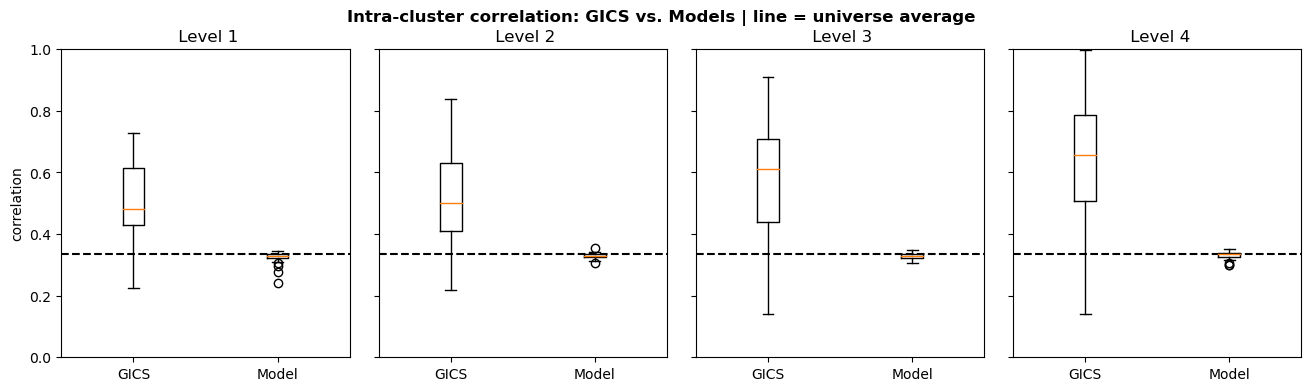

In [22]:
df = pd.DataFrame({
    'Group': ['Level_1', 'Level_2', 'Level_3', 'Level_4'],
    'Value': [Level_1, Level_2, Level_3, Level_4]
})

df2 = pd.DataFrame({
    'Group': ['Level_1_comps', 'Level_2_comps', 'Level_3_comps', 'Level_4_comps'],
    'Value': [Level_1_comps, Level_2_comps, Level_3_comps, Level_4_comps]
})

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharey=True)

for i, ax in enumerate(axs):
    # Add the GICS boxplot to the subplot
    ax.boxplot(df[df['Group'] == f'Level_{i+1}']['Value'], positions=[0.5])
    ax.set_title(f'GICS Level {i+1}')
    ax.set_ylim(0, 1)
    
    # Add the model boxplot to the subplot
    ax.boxplot(df2[df2['Group'] == f'Level_{i+1}_comps']['Value'], positions=[1.5])
    ax.set_title(f' Level {i+1}')
    ax.set_ylim(0, 1)
    
    # Add the horizontal line to the subplot
    avg_cross_correl = (corr_matrix_test.mean().mean() * len(corr_matrix_test)**2 - len(corr_matrix_test)) / (len(corr_matrix_test)**2 - len(corr_matrix_test))
    ax.axhline(avg_cross_correl, color="black", linestyle="--")
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['GICS', 'Model'])

fig.suptitle('Intra-cluster correlation: GICS vs. Models | line = universe average', fontweight='bold')
axs[0].set_ylabel("correlation")

plt.subplots_adjust(wspace=0.1)
plt.show()


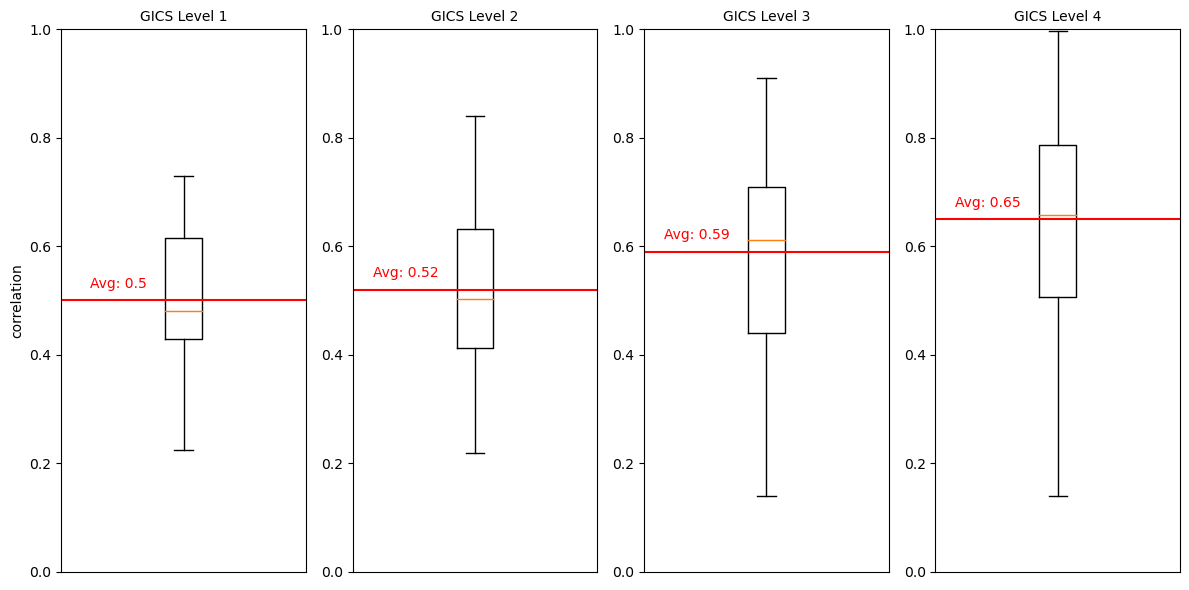

In [23]:
font_size = 15

df = pd.DataFrame({
    'Group': ['Level_1', 'Level_2', 'Level_3', 'Level_4'],
    'Value': [Level_1, Level_2, Level_3, Level_4]
})

fig, axs = plt.subplots(1, 4, figsize=(12, 6))

for i, ax in enumerate(axs):
    # Add the GICS boxplot to the subplot
    data = df[df['Group'] == f'Level_{i+1}']['Value']
    ax.boxplot(data)
    ax.set_title(f'GICS Level {i+1}', fontsize=font_size-5)
    ax.set_ylim(0, 1)
    axs[i].set_xticks([])  # Remove x-axis ticks and labels
    
        # Calculate the average value with two digits
    average = round(np.mean((np.mean(np.mean(data.values)))), 2)
    
    # Add a horizontal line at the average value
    axs[i].axhline(average, color='red')
    
    # Add the average value as a label
    axs[i].text(0.35, average+0.03, f"Avg: {average}", transform=axs[i].get_yaxis_transform(),
                color='red', ha='right', va='center')

#fig.suptitle('avg. intra-cluster correlation: GICS', fontweight='bold', fontsize=font_size)
axs[0].set_ylabel("correlation")

# Adjust the layout
plt.tight_layout()

# Display the plots
plt.show()

## Looking at Cluster Similarity

In [24]:
result_table_11 = three_algos.iloc[:,1:combinations+1]
result_table_25 = three_algos.iloc[:,combinations+1:2*combinations+1]
result_table_67 = three_algos.iloc[:,2*combinations+1:3*combinations+1]
result_table_126 = three_algos.iloc[:,3*combinations+1:]
result_tables =[result_table_11,result_table_25,result_table_67,result_table_126] 

In [25]:
from sklearn.metrics import adjusted_rand_score

def compare_clusters_heatmap(results_table):
    """
    Generates a heatmap to compare the clusters generated by different algorithms.

    Parameters:
    - results_table (pandas DataFrame): A DataFrame containing the clustering results.
      Each row represents a stock, and each column represents a different clustering algorithm.
      The values in the DataFrame are the cluster labels assigned to each stock.

    Returns:
    - None (Displays the heatmap)
    """
    # Calculate the adjusted Rand index for pairwise comparisons of clusterings
    similarity_matrix = pd.DataFrame(index=results_table.columns, columns=results_table.columns, dtype=np.float64)
    for algo1 in results_table.columns:
        for algo2 in results_table.columns:
            similarity_matrix.loc[algo1, algo2] = adjusted_rand_score(results_table[algo1], results_table[algo2])

    # Create a heatmap
    plt.figure(figsize=(30, 12))
    sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
    plt.title('Cluster Comparison Heatmap')
    plt.xlabel('Algorithm')
    plt.ylabel('Algorithm')
    plt.show()


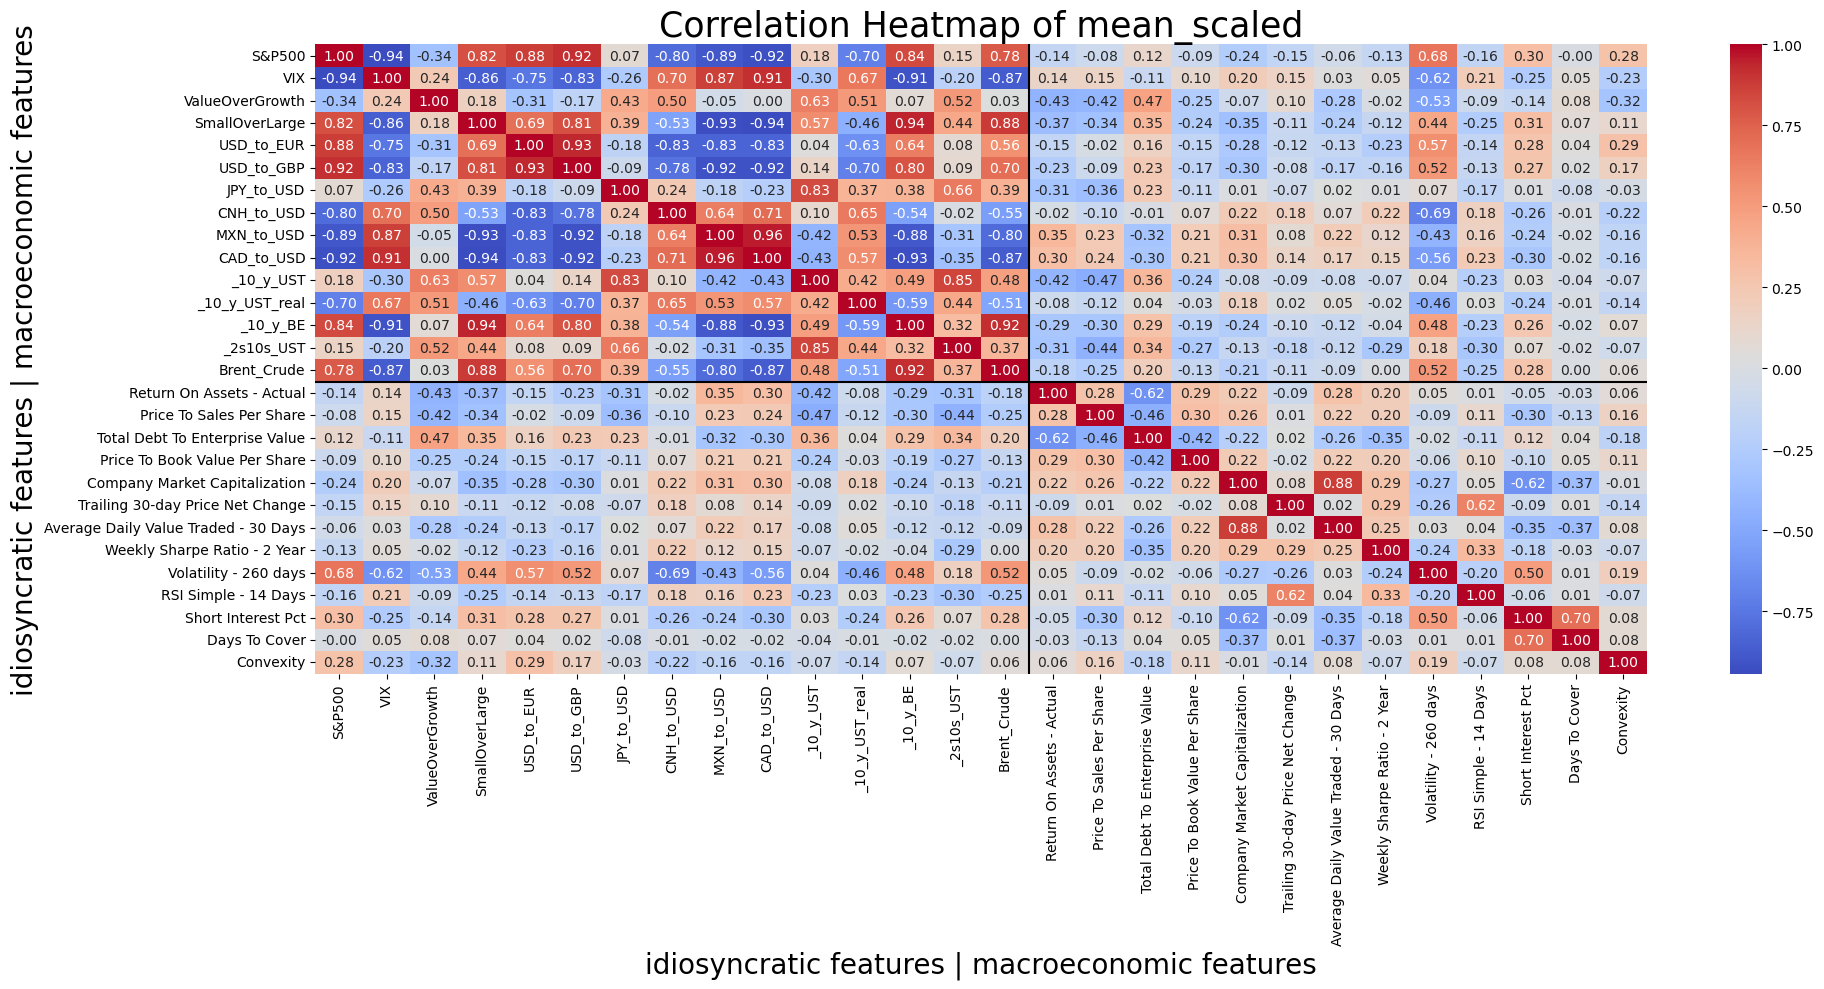

In [26]:
data = mean_scaled.iloc[:,1:]

fontsize = 20
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Set the figure size
plt.figure(figsize=(20, 10))

# Plot the correlation heatmap using seaborn with 2 decimal places
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')

# Add a title to the plot
plt.title('Correlation Heatmap of mean_scaled', fontsize=fontsize+5)

# Draw horizontal and vertical lines after the first 15 rows and columns
heatmap.axhline(y=15, color='k', linestyle='-')
heatmap.axvline(x=15, color='k', linestyle='-')

# Add x and y labels
heatmap.set_xlabel('idiosyncratic features | macroeconomic features', fontsize=fontsize)
heatmap.set_ylabel('idiosyncratic features | macroeconomic features', fontsize=fontsize)


# Use tight layout
plt.tight_layout()

# Display the plot
plt.show()

In [27]:
# load data from desktop
path = r"Dataframes/Model_Description.xlsx"
model_descr = pd.read_excel(path)

model_descr['avg. cluster performance'] = result_means[1:]
model_descr['abs. cluster performance'] = cluster_results[1:]

model_descr = model_descr.set_index(model_descr.columns[0])
model_descr

,algo,depth,feature_style,dimension,avg. cluster performance,abs. cluster performance
model_descr,,,,,,
KMeans_11_mean_ranked,KMeans,11,mean_ranked,full,0.332727,"[0.298, 0.359, 0.365, 0.285, 0.352, 0.271, 0.3..."
GMM_11_mean_ranked,GMM,11,mean_ranked,full,0.330182,"[0.29, 0.341, 0.361, 0.333, 0.339, 0.328, 0.32..."
Hierarchical_11_mean_ranked,Hierarchical,11,mean_ranked,full,0.344273,"[0.343, 0.307, 0.248, 0.359, 0.32, 0.35, 0.431..."
KMeans_11_mean_scaled,KMeans,11,mean_scaled,full,0.326727,"[0.3, 0.382, 0.314, 0.333, 0.364, 0.219, 0.299..."
GMM_11_mean_scaled,GMM,11,mean_scaled,full,0.321000,"[0.381, 0.289, 0.333, 0.259, 0.399, 0.342, 0.3..."
...,...,...,...,...,...,...
GMM_126_scaled_betas_PCA,GMM,126,scaled_betas,PCA,0.325426,"[0.251, 0.414, 0.415, 0.699, 0.516, 0.427, 0.3..."
Hierarchical_126_scaled_betas_PCA,Hierarchical,126,scaled_betas,PCA,0.327070,"[0.028, 0.126, 0.073, 0.192, 0.437, 0.19, -0.0..."
KMeans_126_scaled_correls_PCA,KMeans,126,scaled_correls,PCA,0.316215,"[0.135, 0.508, 0.51, 0.174, -0.078, 0.209, 0.3..."


In [28]:
sorted_df = model_descr.sort_values(by="avg. cluster performance")
sorted_df

,algo,depth,feature_style,dimension,avg. cluster performance,abs. cluster performance
model_descr,,,,,,
Hierarchical_11_scaled_correls_PCA,Hierarchical,11,scaled_correls,PCA,0.242250,"[0.358, 0.318, 0.073, 0.331, 0.461, 0.196, 0.0..."
Hierarchical_11_mean_scaled,Hierarchical,11,mean_scaled,full,0.277375,"[0.203, 0.16, 0.336, 0.345, 0.34, 0.073, 0.382..."
Hierarchical_11_scaled_betas,Hierarchical,11,scaled_betas,full,0.294750,"[0.34, 0.382, 0.196, 0.348, 0.108, 0.229, 0.68..."
GMM_126_scaled_betas,GMM,126,scaled_betas,full,0.298402,"[0.465, 0.403, 0.386, 0.134, 0.481, 0.337, 0.3..."
GMM_126_mean_scaled,GMM,126,mean_scaled,full,0.300309,"[0.392, 0.432, 0.68, 0.543, 0.336, 0.471, 0.22..."
...,...,...,...,...,...,...
GMM_126_ranked_correls,GMM,126,ranked_correls,full,0.346056,"[0.575, 0.344, 0.21, 0.339, 0.312, 0.048, 0.29..."
GMM_67_ranked_betas,GMM,67,ranked_betas,full,0.348045,"[0.243, 0.456, 0.394, 0.23, 0.44, 0.325, 0.37,..."
GMM_126_ranked_betas,GMM,126,ranked_betas,full,0.349127,"[0.21, 0.457, 0.114, 0.148, 0.215, 0.458, 0.66..."


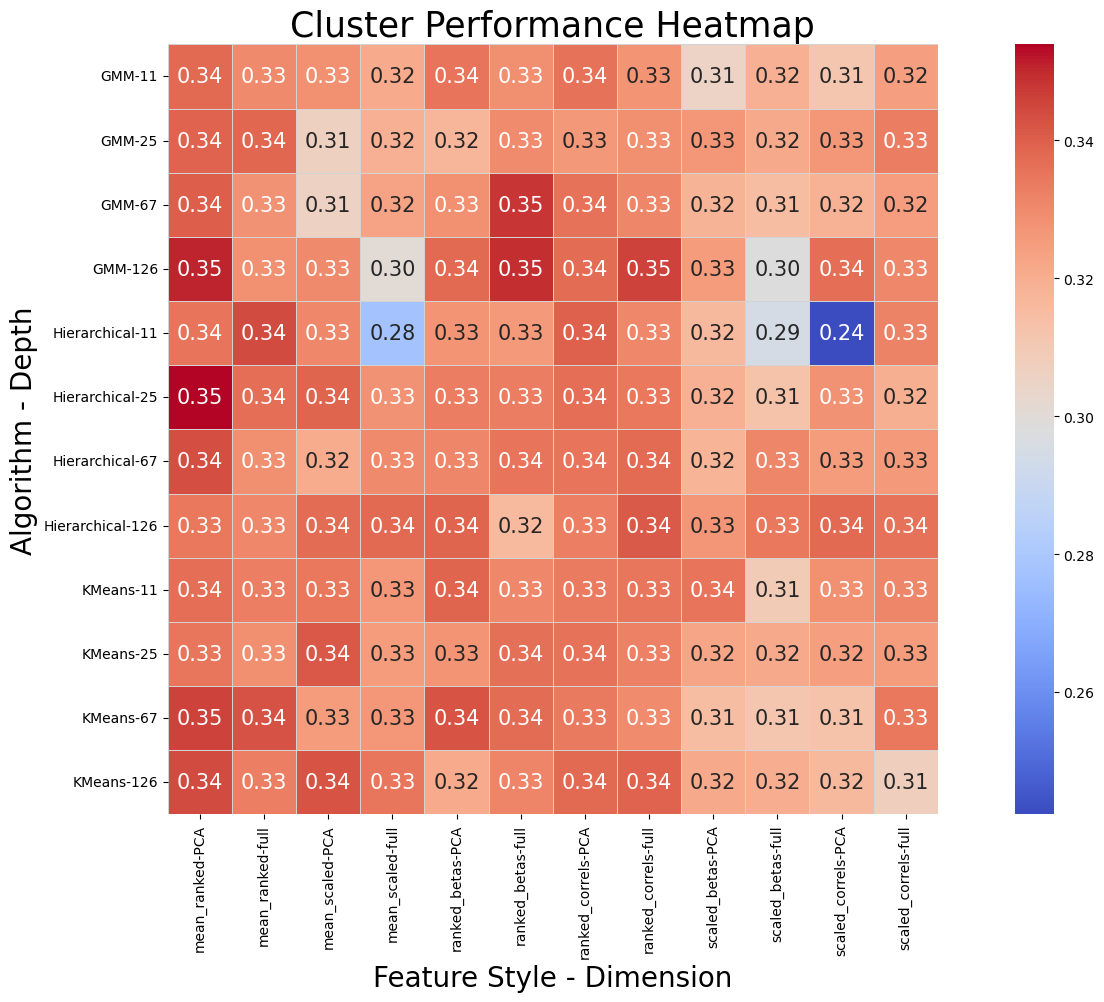

In [29]:
# Set the font size
font_size = 20
model_descr_sorted = model_descr.sort_values('dimension')


# Create a pivot table with the parameters as columns and rows and the score as values
pivot_table = model_descr_sorted.pivot_table(index=['algo', 'depth'], columns=['feature_style', 'dimension'], values='avg. cluster performance')

# Set the figure size
plt.figure(figsize=(20, 10))

# Create a heatmap with specified font size
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".2f", cbar=True, square=True, linewidths=0.5, linecolor='lightgray', annot_kws={"fontsize": font_size-5})

# Set x-axis and y-axis labels with specified font size
plt.xlabel('Feature Style - Dimension', fontsize=font_size)
plt.ylabel('Algorithm - Depth', fontsize=font_size)

# Set title with specified font size
plt.title('Cluster Performance Heatmap', fontsize=font_size+5)

# Display the plot
plt.show()

In [30]:
data = sorted_df.iloc[-4:,:]
display(data)

data.iloc[0:1,-1:]

,algo,depth,feature_style,dimension,avg. cluster performance,abs. cluster performance
model_descr,,,,,,
GMM_67_ranked_betas,GMM,67,ranked_betas,full,0.348045,"[0.243, 0.456, 0.394, 0.23, 0.44, 0.325, 0.37,..."
GMM_126_ranked_betas,GMM,126,ranked_betas,full,0.349127,"[0.21, 0.457, 0.114, 0.148, 0.215, 0.458, 0.66..."
GMM_126_mean_ranked_PCA,GMM,126,mean_ranked,PCA,0.350579,"[0.529, 0.378, 0.304, 0.3, 0.408, 0.367, 0.373..."
Hierarchical_25_mean_ranked_PCA,Hierarchical,25,mean_ranked,PCA,0.353920,"[0.349, 0.294, 0.34, 0.35, 0.215, 0.315, 0.306..."


,abs. cluster performance
model_descr,
GMM_67_ranked_betas,"[0.243, 0.456, 0.394, 0.23, 0.44, 0.325, 0.37,..."


In [31]:
for i in range(4):
    print((data["abs. cluster performance"][i]))

[0.243, 0.456, 0.394, 0.23, 0.44, 0.325, 0.37, 0.369, 0.497, 0.143, 0.327, 0.369, 0.334, 0.521, 0.332, 0.275, 0.304, 0.374, 0.205, 0.289, 0.487, 0.594, 0.248, 0.291, 0.626, 0.232, 0.276, 0.452, 0.19, 0.304, 0.525, 0.215, 0.379, 0.311, 0.271, 0.356, 0.543, 0.396, 0.328, 0.559, 0.369, 0.448, 0.178, 0.309, 0.548, -0.002, 0.391, 0.184, 0.367, 0.447, 0.349, 0.264, 0.512, 0.235, 0.489, 0.247, 0.149, 0.26, 0.276, 0.271, 0.195, 0.461, 0.432, 0.345, 0.21, 0.657]
[0.21, 0.457, 0.114, 0.148, 0.215, 0.458, 0.663, 0.332, 0.599, 0.198, 0.415, 0.148, 0.28, 0.563, 0.535, 0.435, 0.358, 0.678, 0.301, 0.015, 0.529, 0.41, 0.297, 0.543, 0.241, 0.297, 0.073, 0.335, 0.342, 0.246, 0.276, 0.456, 0.447, 0.153, 0.645, 0.721, 0.305, 0.364, 0.217, 0.127, 0.312, 0.405, 0.343, 0.291, 0.206, 0.134, 0.354, 0.438, 0.284, 0.247, -0.039, 0.254, 0.304, 0.443, 0.398, 0.137, 0.309, 0.367, 0.263, 0.611, 0.323, 0.493, 0.574, 0.617, 0.232, 0.559, 0.351, 0.447, 0.483, 0.358, 0.034, 0.209, 0.153, 0.4, 0.323, 0.799, 0.695, 0.308,

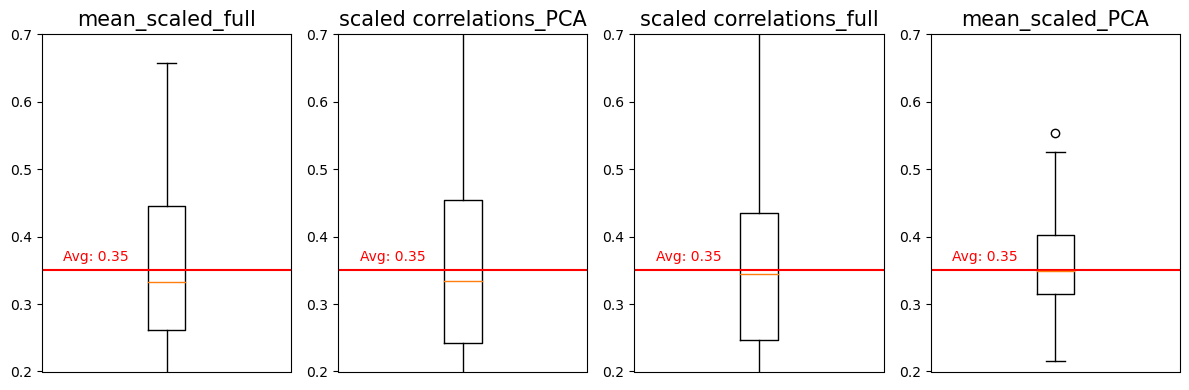

In [32]:
# Assuming your DataFrame is named 'data'

# Create subplots with four plots in one row
fig, axs = plt.subplots(1, 4, figsize=(12, 4))

# Define the titles for the plots
titles = ["mean_scaled_full", "scaled correlations_PCA", "scaled correlations_full", "mean_scaled_PCA"]

# Iterate over the indices and create a violin plot for each
for i in range(4):
    axs[i].boxplot(data["abs. cluster performance"][i])
    axs[i].set_title(titles[i], fontsize=font_size-5)
    axs[i].set_ylim(0.2, 0.7)
    axs[i].set_xticks([])  # Remove x-axis ticks and labels

    # Calculate the average value with two digits
    average = round(np.mean(data["abs. cluster performance"][i]), 2)
    
    # Add a horizontal line at the average value
    axs[i].axhline(average, color='red')
    
    # Add the average value as a label
    axs[i].text(0.35, average+0.02, f"Avg: {average}", transform=axs[i].get_yaxis_transform(),
                color='red', ha='right', va='center')

# Adjust the layout
plt.tight_layout()

# Display the plots
plt.show()
